In [37]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [38]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

housing.data


In [39]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, you need to use the persistence path as the following:
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 15.4MB/s eta 0:00:01


In [40]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
import sys
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

深度学习不仅实现了模型的端到端学习，还推动了人工智能进入工业大生产阶段，产生了标准化、自动化和模块化的通用框架。
不同场景的深度学习模型具备一定的通用性，五个步骤即可完成模型的构建和训练。
![](https://ai-studio-static-online.cdn.bcebos.com/416002c6fdb64a76b13cce2557873fca52da9195d1544292a54cb7f84d62d223)


In [41]:
#加载飞桨、Numpy和相关类库
#fluid包含了大部分飞桨的实用函数
import paddle.fluid as fluid
#dygraph动态图的类库
#动态图模式（解析式执行方式）性能更好更方便调试并便于部署静态图模式（先编译后执行）
import paddle.fluid.dygraph as dygraph
#linear神经网络的全连接层
import paddle.fluid.dygraph as linear
#用于数据处理,数值计算
import numpy as np
import os
import random

In [42]:
#************************ 数据处理 ***********************************
#封装到函数load_data中
def load_data():
    
    import json
    #———————————————————— 读入训练数据 —————————————————————————————
    datafile =  './work/housing.data'
    data = np.fromfile(datafile, sep = ' ')
    
    #———————————————————— 数据形状变换 ————————————————————————————
    #读入之后数据为1维的array
    #由于原始数据为14×1的列向量，故需将其变换为二维形式
    #前13列为特征，最后一列为房价中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS',\
                      'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    feature_num = len(feature_names)
    #这里对原始数据做reshape，变成N×14的形式    
    #reshape(x,y)讲数组拆分成x个长度为y的数组
    #shape输出数组的大小（m×n）
    # data = data[:-3]
    data = data.reshape([data.shape[0] // feature_num, feature_num])
    # data = data.reshape([-1, feature_num])

    #———————————————————— 数据集划分 ———————————————————————————————
    #将80%的数据用作训练集，20%用作测试集
    ratio = 0.8
    #取数据量的80%，强制取整
    offset = int(data.shape[0] * ratio)
    #测试集和训练集必须是没有交集的
    training_data = data[:offset]
   
    #———————————————————— 数据归一化处理 ———————————————————————————
    '''
    使每个特征的取值缩放到0~1之间
    目的：使模型训练更高效；
    特征前的权重大小可以代表该变量对预测结果的贡献度
    （因为每个特征值本身的范围相同）
    '''
    #计算训练数据集的最值和均值
    #axis=0是按列处理（对每一列的所有元素进行相应运算）；axis=1是按行处理
    maximums, minimums, avgs=\
                        training_data.max(axis = 0),\
                        training_data.min(axis = 0),\
                        training_data.sum(axis = 0) / training_data.shape[0]

    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    #对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])
    
    #训练集和测试集为最终返回值
    #[:offset]表示前offset列
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [43]:
#输出测试
#获取数据
training_data, test_data = load_data()
#x = training_data[:, ]
x = training_data[:, :-1]#左闭右开
y = training_data[:, -1:]
#查看数据
print(x[0])
print(y[0])

[-0.02146321  0.03767327 -0.28552309 -0.08663366  0.01289726  0.04634817
  0.00795597 -0.00765794 -0.25172191 -0.11881188 -0.29002528  0.0519112
 -0.17590923]
[-0.00390539]


In [66]:
#************************ 模型设计 ***********************************
#网络设计，相当于模型的假设空间，以实现前向计算
#以“类和对象”的方式描述计算预测的输出
#类成员变量有参数w和b
class Network(object):
    def __init__ (self, num_of_weights):
        #设置固定的随机数种子（为了保持每次运行结果的一致性）
        np.random.seed(0)
        #随机生成w
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
    def forward(self, x):
        z = np.dot(x, self.w)+self.b
        return z 
    #************************ 训练配置 ***********************************
    '''
    通过训练配置优化模型（一般通过损失函数来衡量）
    回归问题中均方误差是一种常见的损失函数形式
    分类问题中常用交叉熵函数
    '''
    #在Network类下面添加损失函数的计算
    #使用定义的Network类可以一次性计算多个样本的预测值和损失函数
    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost
    
    #************************ 训练过程 ***********************************
    #计算w和b的梯度的过程，写成Network类的gradient函数
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z - y) * x
        #特征归一化->为了使统一的步长更加合适
        gradient_w = np.mean(gradient_w, axis = 0)
        # axis = 0 表示把每一行做相加然后再除以总的行数
        #使gradient_w的维度保持在（13，1）
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = z - y
        gradient_b = np.mean(gradient_b)
        return gradient_w, gradient_b
    #———————————————————————— 更新梯度 ——————————————————————————————————————
    def update(self, gradient_w, gradient_b, eta = 0.1):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
    
    #————————————————————————— 封装训练函数 ——————————————————————————————————
    def train(self, training_data, num_epoches, batch_size = 10, eta = 0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epoches):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k: k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                z = self.forward(x)
                loss = self.loss(z, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        return losses

Epoch   0 / iter   0, loss = 2.4674
Epoch   0 / iter   1, loss = 1.5416
Epoch   0 / iter   2, loss = 1.5697
Epoch   0 / iter   3, loss = 1.8539
Epoch   0 / iter   4, loss = 0.5032
Epoch   1 / iter   0, loss = 1.9194
Epoch   1 / iter   1, loss = 1.3654
Epoch   1 / iter   2, loss = 1.2479
Epoch   1 / iter   3, loss = 1.4121
Epoch   1 / iter   4, loss = 0.6061
Epoch   2 / iter   0, loss = 1.0684
Epoch   2 / iter   1, loss = 1.2170
Epoch   2 / iter   2, loss = 1.2545
Epoch   2 / iter   3, loss = 1.2759
Epoch   2 / iter   4, loss = 0.7592
Epoch   3 / iter   0, loss = 0.7891
Epoch   3 / iter   1, loss = 1.1736
Epoch   3 / iter   2, loss = 0.8496
Epoch   3 / iter   3, loss = 1.0019
Epoch   3 / iter   4, loss = 0.7075
Epoch   4 / iter   0, loss = 1.0827
Epoch   4 / iter   1, loss = 0.7817
Epoch   4 / iter   2, loss = 0.6542
Epoch   4 / iter   3, loss = 0.6183
Epoch   4 / iter   4, loss = 0.4101
Epoch   5 / iter   0, loss = 0.9934
Epoch   5 / iter   1, loss = 0.5680
Epoch   5 / iter   2, loss =

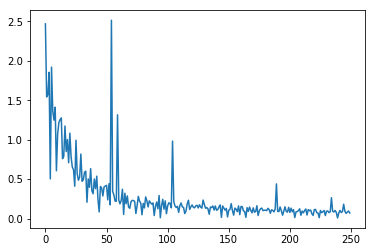

In [67]:
#************************** 训练 *****************************
#获取数据
train_data, test_data = load_data()
#创建网络
net = Network(13)
#启动训练
losses = net.train(train_data, num_epoches = 50, batch_size = 100, eta = 0.01)
#画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

In [ ]:
#测试
#封装训练函数
def train(self, x, y, iterations = 100, eta = 0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            #list.append(obj) 方法向列表的尾部添加一个新的元素
            #obj为返回的对象，该方法无返回值，但是会修改原来的列表
            losses.append(L)
            if (i + 1) % 10 == 0:
                print('iter {}, loaa {}'.format(i, L))
        return losses

iter 9, loaa 1.8984947314576224
iter 19, loaa 1.8031783384598725
iter 29, loaa 1.7135517565541092
iter 39, loaa 1.6292649416831264
iter 49, loaa 1.5499895293373231
iter 59, loaa 1.4754174896452612
iter 69, loaa 1.4052598659324693
iter 79, loaa 1.3392455915676864
iter 89, loaa 1.2771203802372915
iter 99, loaa 1.218645685090292
iter 109, loaa 1.1635977224791534
iter 119, loaa 1.111766556287068
iter 129, loaa 1.0629552390811503
iter 139, loaa 1.0169790065644477
iter 149, loaa 0.9736645220185994
iter 159, loaa 0.9328491676343147
iter 169, loaa 0.8943803798194307
iter 179, loaa 0.8581150257549611
iter 189, loaa 0.8239188186389669
iter 199, loaa 0.7916657692169988
iter 209, loaa 0.761237671346902
iter 219, loaa 0.7325236194855752
iter 229, loaa 0.7054195561163928
iter 239, loaa 0.6798278472589763
iter 249, loaa 0.6556568843183528
iter 259, loaa 0.6328207106387195
iter 269, loaa 0.6112386712285092
iter 279, loaa 0.59083508421862
iter 289, loaa 0.5715389327049418
iter 299, loaa 0.5532835757100

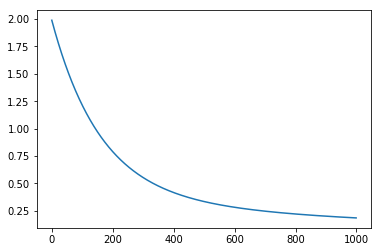

In [61]:
#测试
#获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=1000
#启动训练
losses = net.train(x, y, iterations = num_iterations, eta = 0.01)
#画出损失函数的变化趋势
#numpy.arange(start, stop, step, dtype)
#numpy 包中的使用 arange 函数创建数值范围并返回 ndarray 对象
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

特征输入归一化后，不同参数输出的Loss是一个比较规整的曲线，学习率可以设置成统一的值 ；特征输入未归一化时，不同特征对应的参数所需的步长不一致，尺度较大的参数需要大步长，尺寸较小的参数需要小步长，导致无法设置统一的学习率。
![](https://ai-studio-static-online.cdn.bcebos.com/f92a9cdcee0742ea8e89acdb33e7cc483d03af1b66f34bf3a493f85c2f526113)


In [45]:
#示例
#特征向量x[0]有13个分量,因此需匹配含有13个元素的权重
net = Network(13)
x1 = x[0]
y1 = y[0]
z = net.forward(x1)
print(z)

[-0.63182506]


In [46]:
#示例
net = Network(13)
x1 = x[0:3]
y1 = y[0:3]
z = net.forward(x1)
print(z)
loss = net.loss(z, y1)
print(loss)

[[-0.63182506]
 [-0.55793096]
 [-1.00062009]]
0.7229825055441156


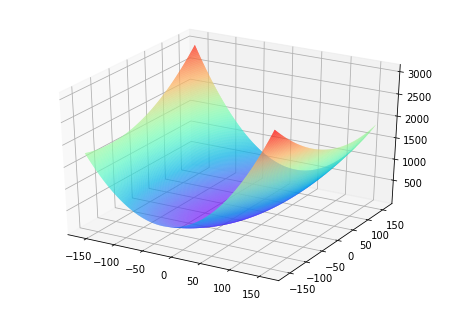

In [47]:
#测试
net = Network(13)
losses = []
#只画出参数w5和w9在区间[-160, 160]的曲线部分，以及包含损失函数的极值
w5 = np.arange(-160.0, 160.0, 1.0)
w9 = np.arange(-160.0, 160.0, 1.0)
losses = np.zeros([len(w5),len(w9)])

#计算设定区域内每个参数取值所对应的loss
#固定w1,w2,...w12不变，只改变w5和w9
#w5和w9对损失函数的影响更为直观
for i in range(len(w5)):
    for j in range(len(w9)):
        net.w[5] = w5[i]
        net.w[9] = w9[j]
        z = net.forward(x)
        loss = net.loss(z, y)
        losses[i, j] = loss

#使用matpplotlib将两个变量和对应的loss作3D图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#使用 Axes3D() 创建 3D 图形对象
#axis3d() 主要是包含了和坐标轴相关的类和方法
ax = Axes3D(fig)

w5, w9 = np.meshgrid(w5, w9)
#np.meshgrid实现用两个坐标轴的点在平面上画网格
#[X,Y] = meshgrid(x,y) 将向量x和y定义的区域转换成矩阵X和Y,其中矩阵X，Y的行向量是向量x，y的简单复制
#假设x是长度为m的向量，y是长度为n的向量，则最终生成的矩阵的维度都是 n*m 
ax.plot_surface(w5, w9, losses, rstride = 1, cstride = 1, cmap = 'rainbow')
plt.show()

#测试
#************************ 训练过程 ***********************************
'''
求解模型参数的过程
目标：找到一组参数使权重最小
对于线性模型而言，最值在梯度为0时获得
梯度方向的反方向是函数值下降最快的方向
使用numpy代替for循环实现快速处理多个样本数据（numpy库广播功能）
'''
z = net.forward(x)
gradient_w = (z - y) * x
#print('gradient_w shape {}'.format(gradient_w.shape))
#print('gradient_w\n',gradient_w)
#取所有样本贡献的梯度的均值
gradient_w = np.mean(gradient_w, axis = 0)
#Q: 为什么先变换维度后进行均值输出维度为（1，13）

'''
print('w', net.w.shape)
#w(13,1)
print('gradient_w', gradient_w.shape)
#graident_w (13,);是因为numpy函数消除了0维所致
'''

#为计算方便将gradient_w的维度也设置为(13, 1)
gradient_w = gradient_w[:, np.newaxis]

gradient_w.shape

In [56]:
# 调用上面定义的gradient函数，计算梯度
# 初始化网络
net = Network(13)
# 设置[w5, w9] = [-100., -100.]
net.w[5] = -100.0
net.w[9] = -100.0

z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

point [-100.0, -100.0], loss 686.3005008179159
gradient [-0.850073323995813, -6.138412364807849]


In [57]:
#测试
#在[w5,w9]平面上，沿着梯度的反方向移动到下一个点
#沿梯度反方向函数值下降
#定义步长(学习率)
eta = 0.1
#更新权重参数
#net.w = net.w - eta * gradient_w
#输出结果与下述代码不同？
#->整个特征均进行了更新，而下述代码值更新了w5和w9两个权重
net.w[5] = net.w[5] - eta * gradient_w5
net.w[9] = net.w[9] - eta * gradient_w9
#重新计算z和loss
z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
#为什么必须先赋值？
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

point [-99.91499266760042, -99.38615876351922], loss 678.6472185028845
gradient [-0.8556356178645292, -6.0932268634065805]


In [63]:
#随机梯度下降法（SGD）
'''
从总的数据集中随机抽取小部分数据来代表整体，基于这部分数据计算梯度和损失来更新参数
mini-batch:迭代抽出的一批数据
batch-size:一个mini-batch包含的样本数目
epoch:按mini-batch逐渐抽取样本，将整个数据集遍历一遍时成为一个epoch
'''
#获取数据
train_data, test_data = load_data()
batch_size = 10
n = len(train_data)
'''
#按顺序获取mini_batch
mini_batches = [train_data[k:k+batch_size] for k in range(0, n, batch_size)]
print('total number of mini_batches is', len(mini_batches))
print('first mini_batch shape', mini_batches[0].shape)
print('last mini_batch shape', mini_batches[-1].shape)
'''

#实现随机抽取mini_batch
'''
模型一般对后出现的数据印象更深刻
越接近模型训练结束的批次的数据对模型参数的影响越大
为避免模型记忆影响训练效果，需要进行样本乱序操作
'''
#np.random.shuffle()随机改变数组顺序
np.random.shuffle(train_data)
#将train_data分为多个mini_batch
mini_batches = [train_data[k:k+mini_batch] for k in range(0, n, batch_size)]
#创建网络
net = Network(13)
#依次使用每个mini_batch的数据
for mini_batch in mini_batches:
    x = mini_batch[:, :-1]
    y = mini_batch[:, -1:]
    loss = net.train(x, y, iterations = 1)


total number of mini_batches is 41
first mini_batch shape (10, 14)
last mini_batch shape (4, 14)
